In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tabulate import tabulate
import seaborn as sns
import scikitplot as skplt
from numpy import percentile
import math

#pandas
from pandas.plotting import parallel_coordinates
from datetime import date, datetime

#sklearn
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer
from sklearn.metrics import plot_confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

#scikitplot
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_lift_curve
from scikitplot.metrics import plot_cumulative_gain

#mlxtend
from mlxtend.plotting import plot_decision_regions

#matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import pyplot

#seaborn
import seaborn as sns

#scipy
import scipy.stats as stats
from scipy.stats import shapiro, mannwhitneyu, normaltest, kstest
from scipy.stats import boxcox, yeojohnson

#wittgenstein
import wittgenstein as lw

In [2]:
def draw_confusion_matrix(clf, X, y, type_flag):
    
    titles_options = [("Confusion matrix, without normalization on %s" %(type_flag), None),
                  ("Normalized confusion matrix on %s" %(type_flag), 'true')]
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(clf, X, y,
                                 cmap='OrRd',
                                 normalize=normalize)
        disp.ax_.set_title(title)
    
    plt.show()

In [3]:
def draw_roc_curve(y_test, y_pred, type_flag):
    
    fig, ax = plt.subplots() #figsize = (13,30)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    roc_auc = roc_auc_score(y_test, y_pred, average=None)
    
    ax.plot(fpr, tpr, color = "#ff7400", label='ROC curve (area = %0.2f)' % (roc_auc))
    ax.plot([0, 1], [0, 1], 'k--', color = '#b42cf0')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate') 
    ax.set_title('Roc curve of the model on %s' %(type_flag))
    ax.tick_params(axis='both')
    ax.legend(loc="lower right", fontsize=14, frameon=False)
    
    fig.tight_layout()
    
    plt.show()

In [4]:
def get_metrics(y_test, y_pred):

    metrics = []
    metrics_names = []

    acc = accuracy_score(y_test, y_pred)
    acc = [float('%.2f' % acc)]
    acc_name = accuracy_score.__name__
    metrics.append(acc)
    metrics_names.append(acc_name)

    f1 = f1_score(y_test, y_pred, labels = [0, 1], average='weighted', zero_division = 1)
    f1 = [float('%.2f' % f1)]
    f1_name = f1_score.__name__
    metrics.append(f1)
    metrics_names.append(f1_name)

    prec = precision_score(y_test, y_pred, labels = [0, 1], average = 'weighted', zero_division= 1)        
    prec = [float('%.2f' % prec)]
    prec_name = precision_score.__name__
    metrics.append(prec)
    metrics_names.append(prec_name)

    rec = recall_score(y_test, y_pred, labels = [0, 1], average = 'weighted', zero_division = 1)
    rec = [float('%.2f' % rec)]
    rec_name = recall_score.__name__
    metrics.append(rec)
    metrics_names.append(rec_name)
    
    
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    
    fpr = [fpr.tolist()]
    fpr_name = 'fpr'
    metrics.append(fpr)
    metrics_names.append(fpr_name)
    
    tpr = [tpr.tolist()]
    tpr_name = 'tpr'
    metrics.append(tpr)
    metrics_names.append(tpr_name)

    auc_score = roc_auc_score(y_test, y_pred, average = None)
    auc_score = [float('%.2f' % auc_score)]
    auc_name = roc_auc_score.__name__
    metrics.append(auc_score)
    metrics_names.append(auc_name)

    metrics = np.array(metrics, dtype = object)
    
    return metrics, metrics_names

In [5]:
def plot_metrics_table(cm, target_names, type_flag, cmap=plt.cm.Pastel1):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    title = 'Metrics of ' + type_flag
    plt.title(title, fontsize=13)
    tick_marks_x = np.arange(0)
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks_x)
    plt.yticks(tick_marks, target_names, fontsize = 12)
    
    plt.tight_layout()

    width, height = cm.shape
    
    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center', fontsize = 11)
    
    plt.show()

In [6]:
def plot_decision_boundary(X_tr, y_tr, model, type_flag):
    
    pca = PCA(n_components=2)
    best_visualization_scaler = StandardScaler()
    
    scaled_X_tr = best_visualization_scaler.fit_transform(X_tr)
    X = pca.fit_transform(scaled_X_tr)
    y = y_tr.values.ravel()

    model.fit(X, y)
    
    fig = plot_decision_regions(X=X, y=y, clf=model, legend=2)
    plt.xlabel("PCA component 1")
    plt.ylabel("PCA component 2")
    plt.title("Model's %s decision boundary" % (type_flag))
    plt.legend(loc='best')
    plt.show()

In [7]:
def plot_selected_features_anova(X_tr, clf, best_params, type_flag):
    
    dfscores = pd.DataFrame(clf['reduce_dim'].scores_)
    dfcolumns = pd.DataFrame(X_tr.columns)

    featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
    featureScores.columns = ['Feature', 'Score']
    featureScores = featureScores[featureScores['Score'] != 0]

    best_k = best_params['reduce_dim__k']
    
    # plot feature importance
    fig = plt.figure(figsize=(8, 10))
    
    # keeping ongly best_k features, ordered in descending score
    ordered_k_feature_scores = featureScores.sort_values('Score', ascending=False).iloc[:best_k]
    
    sns.barplot(y='Feature', x='Score', data=featureScores, color= "#ff7400",
                                                            order=ordered_k_feature_scores.Feature)
    
    plt.title("%s feature importance using %s" % (type_flag, 'ANOVA'))
    plt.show()

In [8]:
def plot_classification_report(y_test, y_pred, type_flag):
    
    model_report = classification_report(y_test, y_pred, output_dict=True)
    
    model_r = pd.DataFrame(model_report).iloc[:-1, :].T
    
    sns.heatmap(model_r, annot=True, cmap='OrRd', cbar=False)
    
    plt.title("%s classification report" % (type_flag))
    
    plt.show()

<h1>Divide into features and target</h1>

<h2>Training merged</h2>

In [9]:
X_train_merged = pd.read_csv('X_train_merged.csv', index_col=0)
y_train = pd.read_csv('y_train_merged.csv', index_col=0)

In [10]:
print("Original Training merged:", X_train_merged.shape)

Original Training merged: (92834, 55)


In [11]:
attributes = [col for col in X_train_merged.columns]

<h2>Test</h2>

In [12]:
X_test = pd.read_csv('X_test.csv', index_col=0)
y_test = pd.read_csv('y_test.csv', index_col=0)

In [13]:
print("Original Test:", X_test.shape)

Original Test: (10874, 55)


In [14]:
X_test = X_test.values

<h2>Analysis</h2>

**Define the hyperparameters to tune**

In [15]:
param_grid = {"prune_size": [0.1, 0.25, 0.33, 0.5],
              "k": [1, 2, 3]}

**Grid search**

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'k': 1, 'prune_size': 0.25}
<RIPPER(k=1, max_rule_conds=None, random_state=42, n_discretize_bins=10, max_total_conds=None, max_rules=None, verbosity=0, prune_size=0.25, dl_allowance=64)>


base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [187, 188, 189, 555, 623, 626, 925, 926, 927, 928, 930, 934, 936, 937, 1870, 1871, 1872, 1873, 1875, 1876, 2215, 2216, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 3310, 3455, 3457, 3459, 3514, 3515, 3526, 3527, 3528, 3529, 3530, 3532, 3755, 3879, 3880, 3882, 3883, 3884, 3976, 4087, 4532, 4533, 4534, 4535, 5828, 8426, 10684]
 Consider running recalibrate_proba with smaller param min_samples, or set require_min_samples=False



Confusion matrix


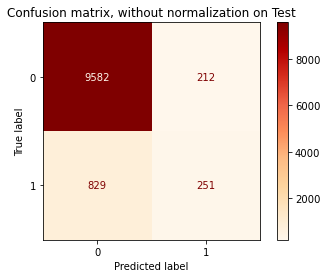

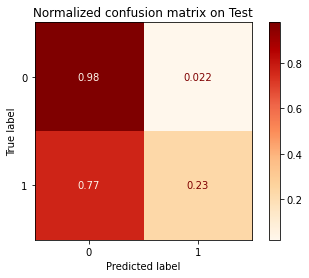

Classification report
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      9794
           1       0.54      0.23      0.33      1080

    accuracy                           0.90     10874
   macro avg       0.73      0.61      0.64     10874
weighted avg       0.88      0.90      0.89     10874




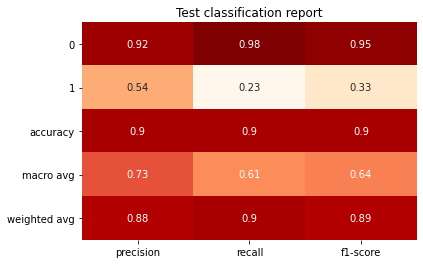

Metrics


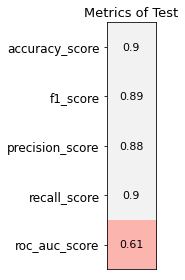



Roc curve



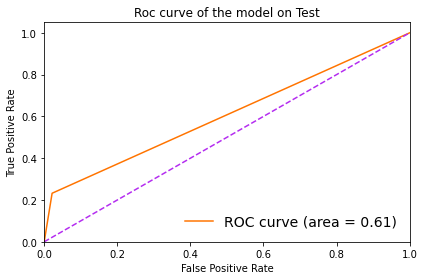


Lift Curve


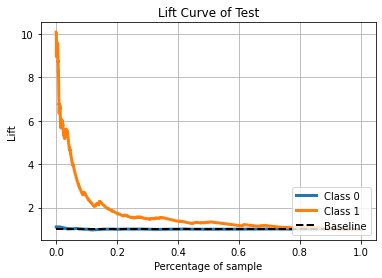

Roc Curves


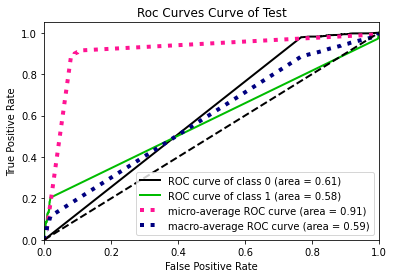

Precision Recall Curve


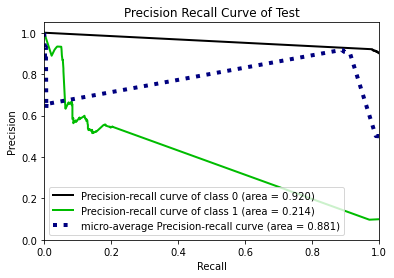

Cumulative Gains Curve


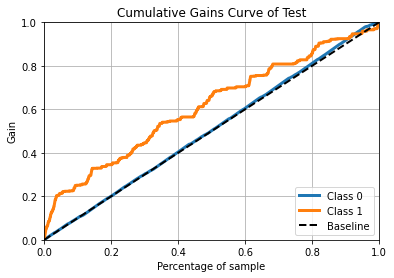

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'k': 1, 'prune_size': 0.33}
<RIPPER(k=1, max_rule_conds=None, random_state=42, n_discretize_bins=4, max_total_conds=None, max_rules=None, verbosity=0, prune_size=0.33, dl_allowance=64)>


base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [620, 919, 920, 1438, 1440, 1447, 1878, 1879, 1880, 1882, 1883, 1887, 1910, 1911, 3591, 3611, 3880, 3884, 4506, 4507, 4879, 4880, 4884, 4885, 5152, 5920, 6657, 9410, 9413, 10830, 10832, 10833]
 Consider running recalibrate_proba with smaller param min_samples, or set require_min_samples=False



Confusion matrix


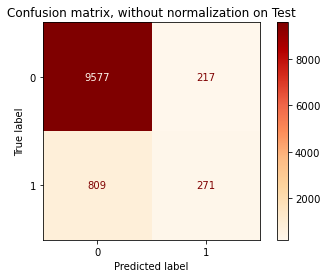

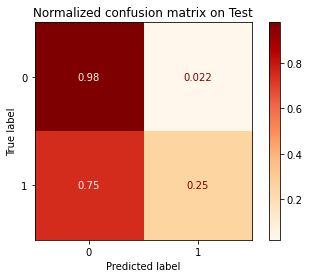

Classification report
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      9794
           1       0.56      0.25      0.35      1080

    accuracy                           0.91     10874
   macro avg       0.74      0.61      0.65     10874
weighted avg       0.89      0.91      0.89     10874




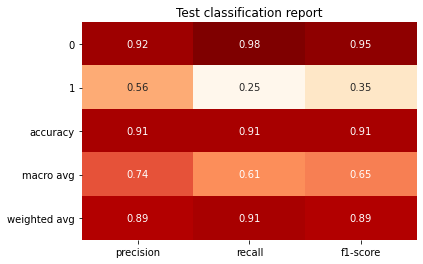

Metrics


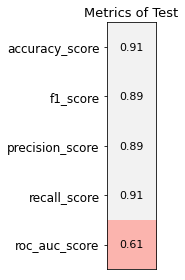



Roc curve



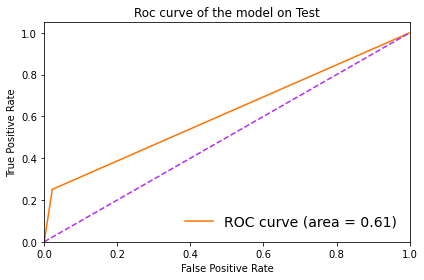


Lift Curve


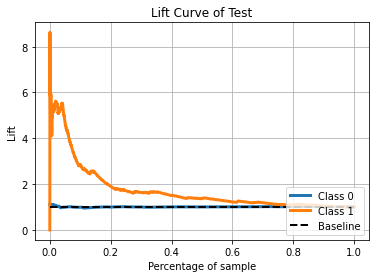

Roc Curves


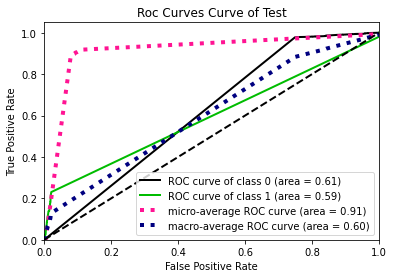

Precision Recall Curve


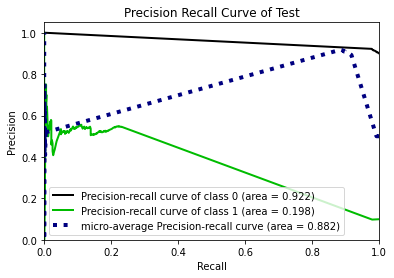

Cumulative Gains Curve


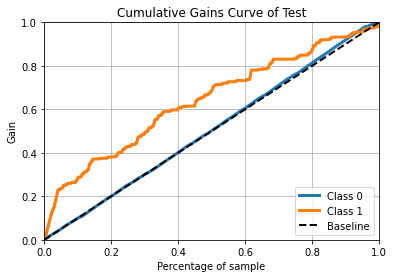

In [16]:
ripper_names = ['Ripper_10bins', 'Ripper_4bins']
type_flag = "Test"

dict_metrics_ripper = dict()

for name in ripper_names:
    
    if name == 'Ripper_10bins':
        ripper_clf = lw.RIPPER(random_state=42)
    else:
        ripper_clf = lw.RIPPER(random_state=42, n_discretize_bins = 4)

    k_fold = StratifiedKFold(n_splits=3) 

    grid_search = GridSearchCV(estimator = ripper_clf, param_grid = param_grid, scoring = 'f1_weighted', cv = k_fold, refit = 'f1_weighted', verbose = 3, n_jobs = -1)

    grid_search.fit(X_train_merged.values, y_train.values.ravel())

    print(grid_search.best_params_)
    print(grid_search.best_estimator_)

    best_params = grid_search.best_params_
    clf = grid_search.best_estimator_

    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)

    metrics, metrics_names = get_metrics(y_test, y_pred)

    dict_metrics_ripper[name] = {}
    for m, n in zip(metrics, metrics_names):
        dict_metrics_ripper[name][n] = m[0]

    dict_metrics_ripper[name]['model'] = clf
    dict_metrics_ripper[name]['best_params'] = best_params
    dict_metrics_ripper[name]['ruleset'] = clf.ruleset_

    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    draw_confusion_matrix(clf, X_test, y_test, type_flag)

    #classification report
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
    print()
    plot_classification_report(y_test, y_pred, type_flag)

    #metrics
    metrics2 = [i for i in metrics]
    metrics2.pop(4)
    metrics2.pop(4)
    metrics2 = np.array(metrics2, dtype = float)

    metrics_names2 = [i for i in metrics_names]
    metrics_names2.remove('fpr')
    metrics_names2.remove('tpr')

    print('\033[1m'"Metrics"'\033[0m')
    plot_metrics_table(metrics2, metrics_names2, type_flag)

    print()
    print()

    #roc curve
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    draw_roc_curve(y_test, y_pred, type_flag)

    print()

    #lift curve
    print('\033[1m'"Lift Curve"'\033[0m')
    title = "Lift Curve of " + type_flag
    plot_lift_curve(y_test, y_score, title)
    plt.show()

    #roc curves
    print('\033[1m'"Roc Curves"'\033[0m')
    title = "Roc Curves Curve of " + type_flag
    plot_roc(y_test, y_score, title)
    plt.show()

    #precision-recall curve
    print('\033[1m'"Precision Recall Curve"'\033[0m')
    title = "Precision Recall Curve of " + type_flag
    plot_precision_recall(y_test, y_score, title)
    plt.show()

    #cumulative gains curve
    print('\033[1m'"Cumulative Gains Curve"'\033[0m')
    title = "Cumulative Gains Curve of " + type_flag
    plot_cumulative_gain(y_test, y_score, title)
    plt.show()